# Initial Data Pipeline, Simple LSTM Model, and Evaluation Framework

### Confirm Environment Setup

In [1]:
!conda info


     active environment : tensorflow-gpu
    active env location : /shared/EL9/explorer/anaconda3/2024.06/envs/tensorflow-gpu
            shell level : 2
       user config file : /home/neiderer.c/.condarc
 populated config files : 
          conda version : 24.5.0
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=broadwell
                          __conda=24.5.0=0
                          __cuda=12.3=0
                          __glibc=2.34=0
                          __linux=5.14.0=0
                          __unix=0=0
       base environment : /shared/EL9/explorer/anaconda3/2024.06  (read only)
      conda av data dir : /shared/EL9/explorer/anaconda3/2024.06/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://rep

In [2]:
# Figure out if using GPU or CPU
import tensorflow as tf

def detect_and_set_device():
    if tf.test.is_built_with_cuda() or platform.system() == "Darwin":
        physical_devices = tf.config.list_physical_devices('GPU')
        if len(physical_devices) > 0:
            print("GPU is available. Using GPU.")
            try:
                for gpu in physical_devices:
                    tf.config.experimental.set_memory_growth(gpu, True)
                return 'GPU'
            except RuntimeError as e:
                print(f"Unable to set memory growth: {e}")
                return 'CPU'
    print("GPU is not available. Using CPU.")
    return 'CPU'

detect_and_set_device()

2025-07-01 11:20:18.142835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751383218.163756 3361441 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751383218.170262 3361441 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751383218.186865 3361441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751383218.186884 3361441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751383218.186886 3361441 computation_placer.cc:177] computation placer alr

GPU is available. Using GPU.


'GPU'

In [3]:
# Setup pandas display attributes
import pandas as pd

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

### Load Data

In [4]:
df = pd.read_csv('../data/mental_health_sentiment.csv', index_col=0) 
# Rename text and label columns to be generic
df.rename(columns={"statement": "text", "status": "label"}, inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    52681 non-null  object
 1   label   53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,I've shifted my focus to something else but I'm still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


In [5]:
df["label"].value_counts()

label
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

### Text Preprocessing

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", '', text)              # remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neiderer.c/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/neiderer.c/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Encode Sentiment Labels

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

# Print encoding map for reference
label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_map)

{'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label_encoded']

# 80-20 stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Text Vectorization

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [10]:
# Filter out empty sequences
non_empty_train = X_train_pad.sum(axis=1) > 0
X_train_pad = X_train_pad[non_empty_train]
y_train = y_train[non_empty_train]

non_empty_test = X_test_pad.sum(axis=1) > 0
X_test_pad = X_test_pad[non_empty_test]
y_test = y_test[non_empty_test]

### Build Sentiment Model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

embedding_dim = 128

# # Simple Long Short Term Memory (LSTM) Model
# print("Simple LSTM Model")
# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
#     LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
#     Dropout(0.3),
#     LSTM(64),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(7, activation='softmax')
# ])

# Bidirectional LSTM Model
print("Simple Bidirectional LSTM Model")
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))
model.summary()

Simple Bidirectional LSTM Model


/shared/EL9/explorer/anaconda3/2024.06/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1751383247.195505 3361441 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,711,879 (6.53 MB)

 Trainable params: 1,711,879 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=3,               
    restore_best_weights=True,
    verbose=1
)

# checkpoint = ModelCheckpoint(
#     filepath=model_file,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=0
# )

# Set random seed for tensorflow repeatability
tf.random.set_seed(42)

In [13]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20


I0000 00:00:1751383252.320926 3361493 cuda_dnn.cc:529] Loaded cuDNN version 90501


1323/1323 ━━━━━━━━━━━━━━━━━━━━ 47s 31ms/step - accuracy: 0.5761 - loss: 1.0909 - val_accuracy: 0.7038 - val_loss: 0.7309
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7403 - loss: 0.6724 - val_accuracy: 0.7407 - val_loss: 0.6652
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7932 - loss: 0.5475 - val_accuracy: 0.7615 - val_loss: 0.6382
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8271 - loss: 0.4634 - val_accuracy: 0.7539 - val_loss: 0.6915
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8473 - loss: 0.4110 - val_accuracy: 0.7604 - val_loss: 0.7270
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.8716 - loss: 0.3565 - val_accuracy: 0.7597 - val_loss: 0.7804
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


### Evaluate Model Performance

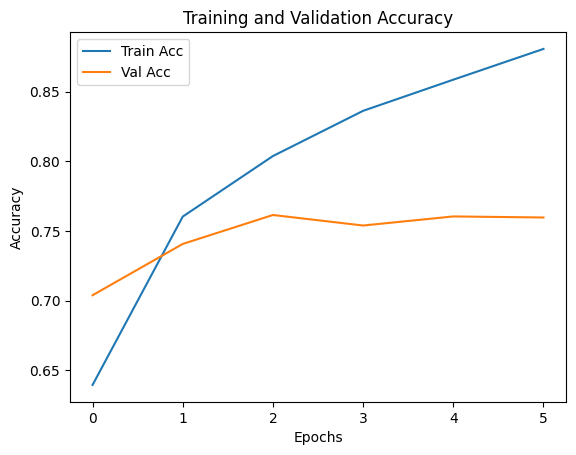

331/331 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
                      precision    recall  f1-score   support

             Anxiety       0.76      0.81      0.78       778
             Bipolar       0.81      0.72      0.76       575
          Depression       0.75      0.66      0.70      3081
              Normal       0.87      0.95      0.91      3250
Personality disorder       0.53      0.53      0.53       240
              Stress       0.62      0.39      0.48       534
            Suicidal       0.64      0.74      0.69      2131

            accuracy                           0.76     10589
           macro avg       0.71      0.68      0.69     10589
        weighted avg       0.76      0.76      0.76     10589



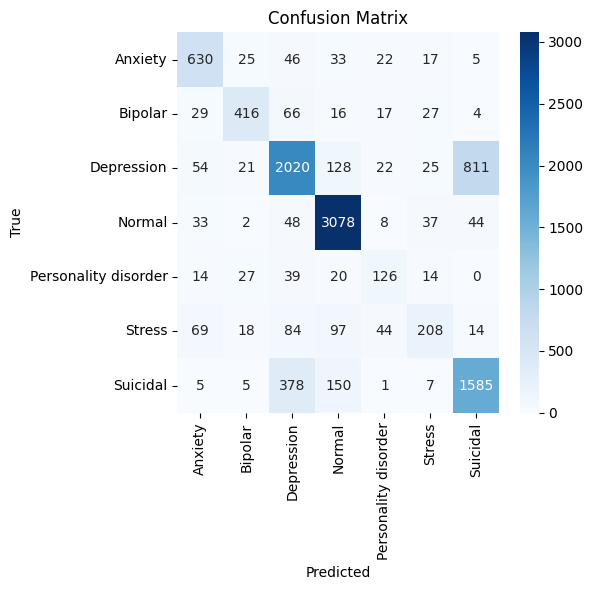

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

# Predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt='d', cmap="Blues", ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("../figures/bilstm_confusion_matrix.png")
plt.show()

### Build Sentiment Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

embedding_dim = 128

# Simple Long Short Term Memory (LSTM) Model
print("Simple LSTM Model")
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# # Bidirectional LSTM Model
# print("Simple Bidirectional LSTM Model")
# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
#     Bidirectional(LSTM(128, return_sequences=True)),
#     Dropout(0.3),
#     Bidirectional(LSTM(64)),
#     Dense(32, activation='relu'),
#     Dropout(0.2),
#     Dense(7, activation='softmax')
# ])

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy']
)

model.build(input_shape=(None, max_len))
model.summary()

Simple LSTM Model


/shared/EL9/explorer/anaconda3/2024.06/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,463,303 (5.58 MB)

 Trainable params: 1,463,303 (5.58 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',    
    patience=3,               
    restore_best_weights=True,
    verbose=1
)

# checkpoint = ModelCheckpoint(
#     filepath=model_file,
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=0
# )

# Set random seed for tensorflow repeatability
tf.random.set_seed(42)

In [17]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 128s 94ms/step - accuracy: 0.4707 - loss: 1.3630 - val_accuracy: 0.6519 - val_loss: 0.8381
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 123s 93ms/step - accuracy: 0.6557 - loss: 0.8381 - val_accuracy: 0.6913 - val_loss: 0.7707
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.7236 - loss: 0.7124 - val_accuracy: 0.7265 - val_loss: 0.7240
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 164s 124ms/step - accuracy: 0.7711 - loss: 0.6032 - val_accuracy: 0.7411 - val_loss: 0.6933
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.8080 - loss: 0.5214 - val_accuracy: 0.7469 - val_loss: 0.6980
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.8336 - loss: 0.4613 - val_accuracy: 0.7519 - val_loss: 0.7342
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy: 0.8530 - loss: 0.4127 - val_accuracy: 0.7497 - val_loss: 0.7606
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 122s 92ms/step - accuracy:

### Evaluate Model Performance

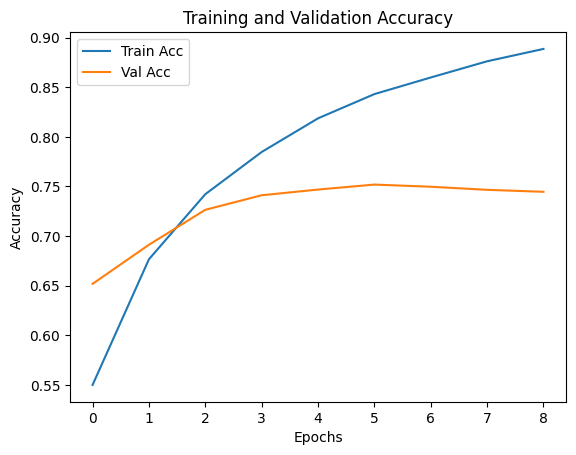

331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
                      precision    recall  f1-score   support

             Anxiety       0.76      0.77      0.77       778
             Bipolar       0.80      0.74      0.77       575
          Depression       0.76      0.64      0.70      3081
              Normal       0.88      0.92      0.90      3250
Personality disorder       0.48      0.66      0.55       240
              Stress       0.54      0.46      0.50       534
            Suicidal       0.62      0.73      0.67      2131

            accuracy                           0.75     10589
           macro avg       0.69      0.70      0.69     10589
        weighted avg       0.76      0.75      0.75     10589



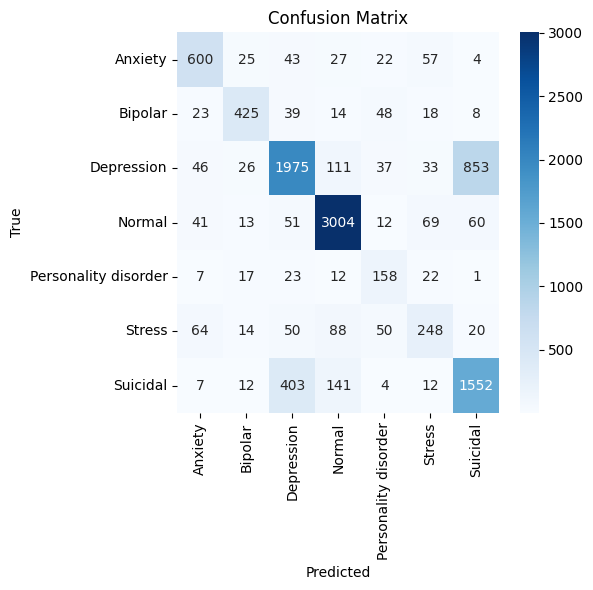

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()

# Predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt='d', cmap="Blues", ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("../figures/lstm_confusion_matrix.png")
plt.show()

### Sandbox